<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Run-sigma-sweep" data-toc-modified-id="Run-sigma-sweep-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Run sigma sweep</a></span></li><li><span><a href="#Plot-persistent-time-vs-sigma" data-toc-modified-id="Plot-persistent-time-vs-sigma-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Plot persistent time vs sigma</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#The-encoded-persistent-time-is-weak" data-toc-modified-id="The-encoded-persistent-time-is-weak-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The encoded persistent time is weak</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#The-function-spends-most-of-the-time-when-the-currents-are-close-to-each-other" data-toc-modified-id="The-function-spends-most-of-the-time-when-the-currents-are-close-to-each-other-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>The function spends most of the time when the currents are close to each other</a></span></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## General parameters

In [2]:
epsilon = 10e-80
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Run sigma sweep

In [3]:
def run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=0.050):

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    tau_s = manager.nn.tau_s
    T_recall = T_persistence * manager.nn.minicolumns
    T_cue = 2 * tau_s
    nr = manager.canonical_network_representation
    n_patterns = len(nr)

    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                              reset=True, empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection,
                   'persistent times': persistent_times_collection, 'sequences': sequence_collection,
                   'T_persistence': T_persistence}

    return results_dic

#### Plot persistent time vs sigma

In [4]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    low = mean_persistent - std
    low[low < tau_s] = tau_s
    high = mean_persistent + std
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

# The encoded persistent time is weak

## An example

In [5]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 1.000

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 0.1

results_dictionary_simple = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

CPU times: user 3min 16s, sys: 644 ms, total: 3min 17s
Wall time: 3min 17s


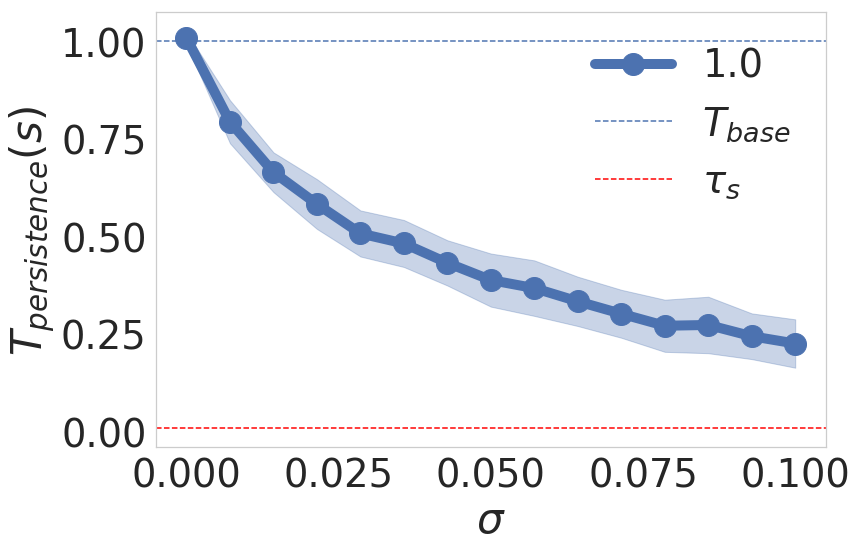

In [6]:
results_dictionary = results_dictionary_simple
label = str(T_persistence)
index = 0
ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=None)

In [7]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 1.000

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 2.0

results_dictionary_simple = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

CPU times: user 3min 6s, sys: 116 ms, total: 3min 6s
Wall time: 3min 6s


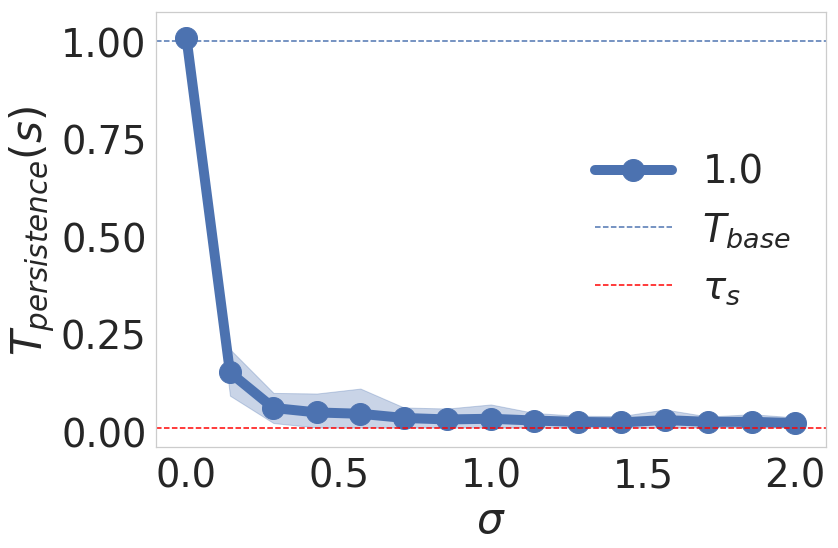

In [8]:
results_dictionary = results_dictionary_simple
label = str(T_persistence)
index = 0
ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=None)

In [9]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 3.000

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)


sigma_number = 15
samples = 25
sigma_max = 1.0

results_dictionary_simple = run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=T_persistence)

CPU times: user 8min 53s, sys: 344 ms, total: 8min 54s
Wall time: 8min 54s


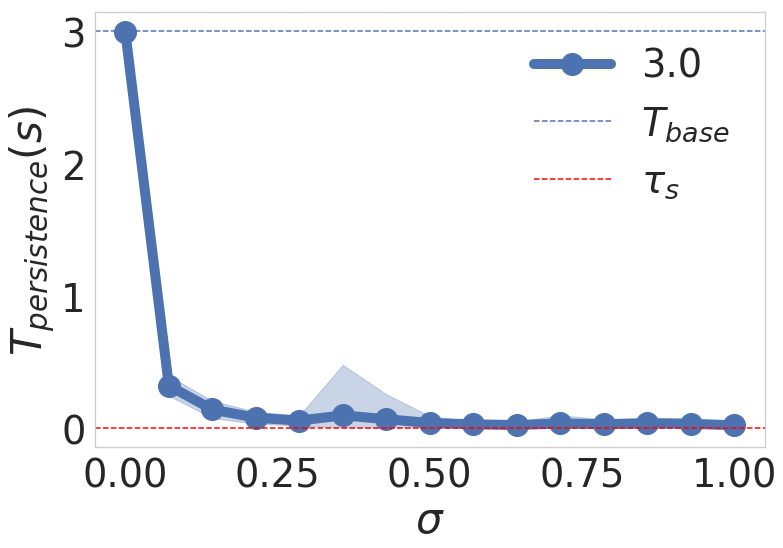

In [10]:
results_dictionary = results_dictionary_simple
label = str(T_persistence)
index = 0
ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=None)

## The function spends most of the time when the currents are close to each other

In [11]:
def s_diff(t, nn):
    B_times_g_a = nn.beta[1] - nn.beta[2] + nn.w[1, 1] - nn.w[2, 1]
    return B_times_g_a - nn.g_a*(1 - np.exp(-t/tau_a)/(1 - nn.r))

In [12]:
time = np.linspace(0, T_persistence, num=100)
y = s_diff(time, nn) / s_diff(0, nn)

$s_{diff} = B * g_a - g_a (1 - e^{-\frac{t}{\tau_a}}) $

Note that the function above is normalized 

(1.0, 0.0)

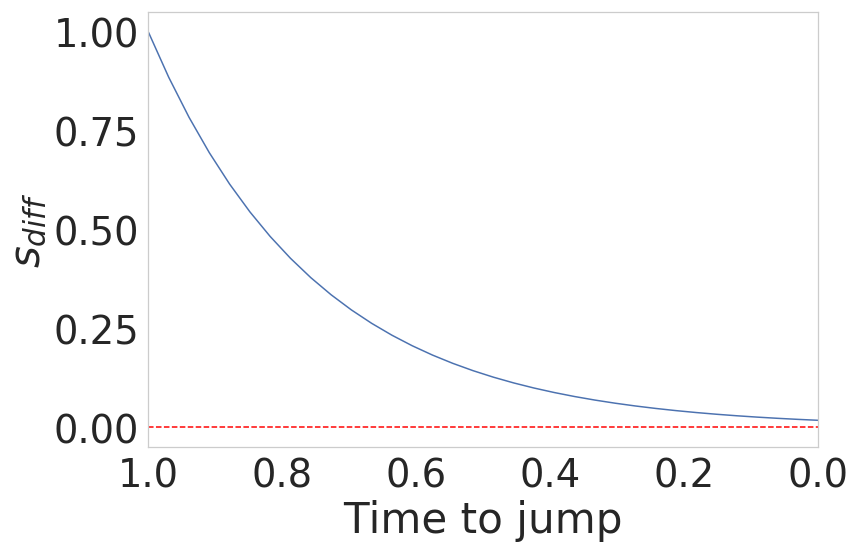

In [13]:
plt.plot(1 - time, y)
plt.ylabel(r'$s_{diff}$')
plt.xlabel(r'Time to jump')

t_50 = 0.50 * T_persistence
s_50 = s_diff(t_50, nn) / s_diff(0, nn)
plt.axhline(s_50, ls='--', color='red')
plt.axvline(t_50, ls='-', color='red')

plt.xlim([1.0, 0.0])


So the axis are normalized here where s_diff = 1 implies the maximum difference when the unit just kicked in. 0 is the time at which the transition for the next unit is. We see that by the time that half of the persistent time has elapsed the the current is already less than a quarter away from breaking. This implies that if there is noise it will easily make the unit transition. 